### Setup

In [1]:
import pandas as pd
import numpy as np
import os
from time import time

In [2]:
from vb_estimators import  LinRegSupreme,LinSVR,RBFSVR,ENet,L1Lars,GBR,HGBR,FlexiblePipe
from vb_helper import VBHelper
from vb_cross_validator import regressor_q_stratified_cv
from missing_val_transformer import missingValHandler

no daal4py


In [3]:

from warnings import filterwarnings
filterwarnings('ignore')


### setup the experiment/project
#### note the 'run_stacked' kwarg that can be set to create the stacked_regressor

In [4]:
gridpoints=5
kwargs=dict(
    run_stacked=True,
    test_share=0,#keep at 0 for small datasets
    cv_folds=5,
    cv_reps=2,
    #cv_groupcount=5,
    cv_strategy=('quantile',5), # for stratified cv
    random_state=2 # random_state for reproducibility
)
vbhelper=VBHelper(**kwargs)

In [5]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
vbhelper.scorer_list=scorer_list

##### User Import Dataset Step

In [6]:
data_path=os.path.join('sample_data','ex1.csv')
df=pd.read_csv(data_path)
all_vars=list(df.columns)
print(all_vars)

['STA_ID', 'LONG', 'LAT', 'OrigHabCode', 'Date', 'THG_Fish', 'YEAR', 'SEASON', 'SUBAREA', 'HABCODE', 'Floc_Depth_ft', 'AFDW_Floc', 'MEHG_Floc', 'THG_floc', 'Tot_Phos_floc', 'Bulk_Dens_Floc', 'Soil_Thickness_FT', 'AFDW_Soil', 'Bulk_Dens_Soil', 'PH_soil', 'SO4_soil', 'MEHG_soil', 'THG_soil', 'Tot_Carbon_Soil_%', 'Tot_Nitrogen_Soil_%', 'Tot_Phos_soil', 'Wat_Depth_ft', 'COND_SW', 'DO_SW', 'TEMP_SW', 'PH_SW', 'TURB_SW', 'REDOX_SW', 'Alk_Phos_SW', 'CHLA_SW', 'CL_SW', 'MEHG_SW', 'NH4_SW', 'NO2_SW', 'NO3_SW', 'SO4_SW', 'Sol_Reac_Phos_SW', 'THG_SW', 'TOC_SW', 'Tot_Nitrogen_SW', 'Tot_Phos_SW', 'REDOX_PW', 'H2S_PW', 'Sol_Reac_Phos_PW', 'MEHG_Peri_AVG', 'THG_epi_peri']


In [7]:
shuf=np.arange(df.shape[0])
print(df.shape)
seed=0
rng = np.random.default_rng(seed)
rng.shuffle(shuf)
df=df.iloc[shuf]

(774, 51)


#### user has option to specify "regulatory standard"

In [8]:
#The user sets the variables to use for x and y.
y_name='THG_Fish'
loc_vars=['LAT','LONG']
drop_vars=['Date','OrigHabCode','STA_ID']
drop_vars.extend(loc_vars)
drop_vars.append(y_name)
x_vars=[var for var in all_vars if var not in drop_vars]

predict_n=2
print(df.shape)
X_df=df.loc[:,x_vars].iloc[predict_n:]
print(X_df.shape)
X_predict=df.loc[:,x_vars].iloc[:predict_n]
y_df=df.loc[:,y_name].iloc[predict_n:]
y_predict=df.loc[:,y_name].iloc[:predict_n]


(774, 51)
(772, 45)


In [9]:
vbhelper.setData(X_df,y_df)

Take a look at the data

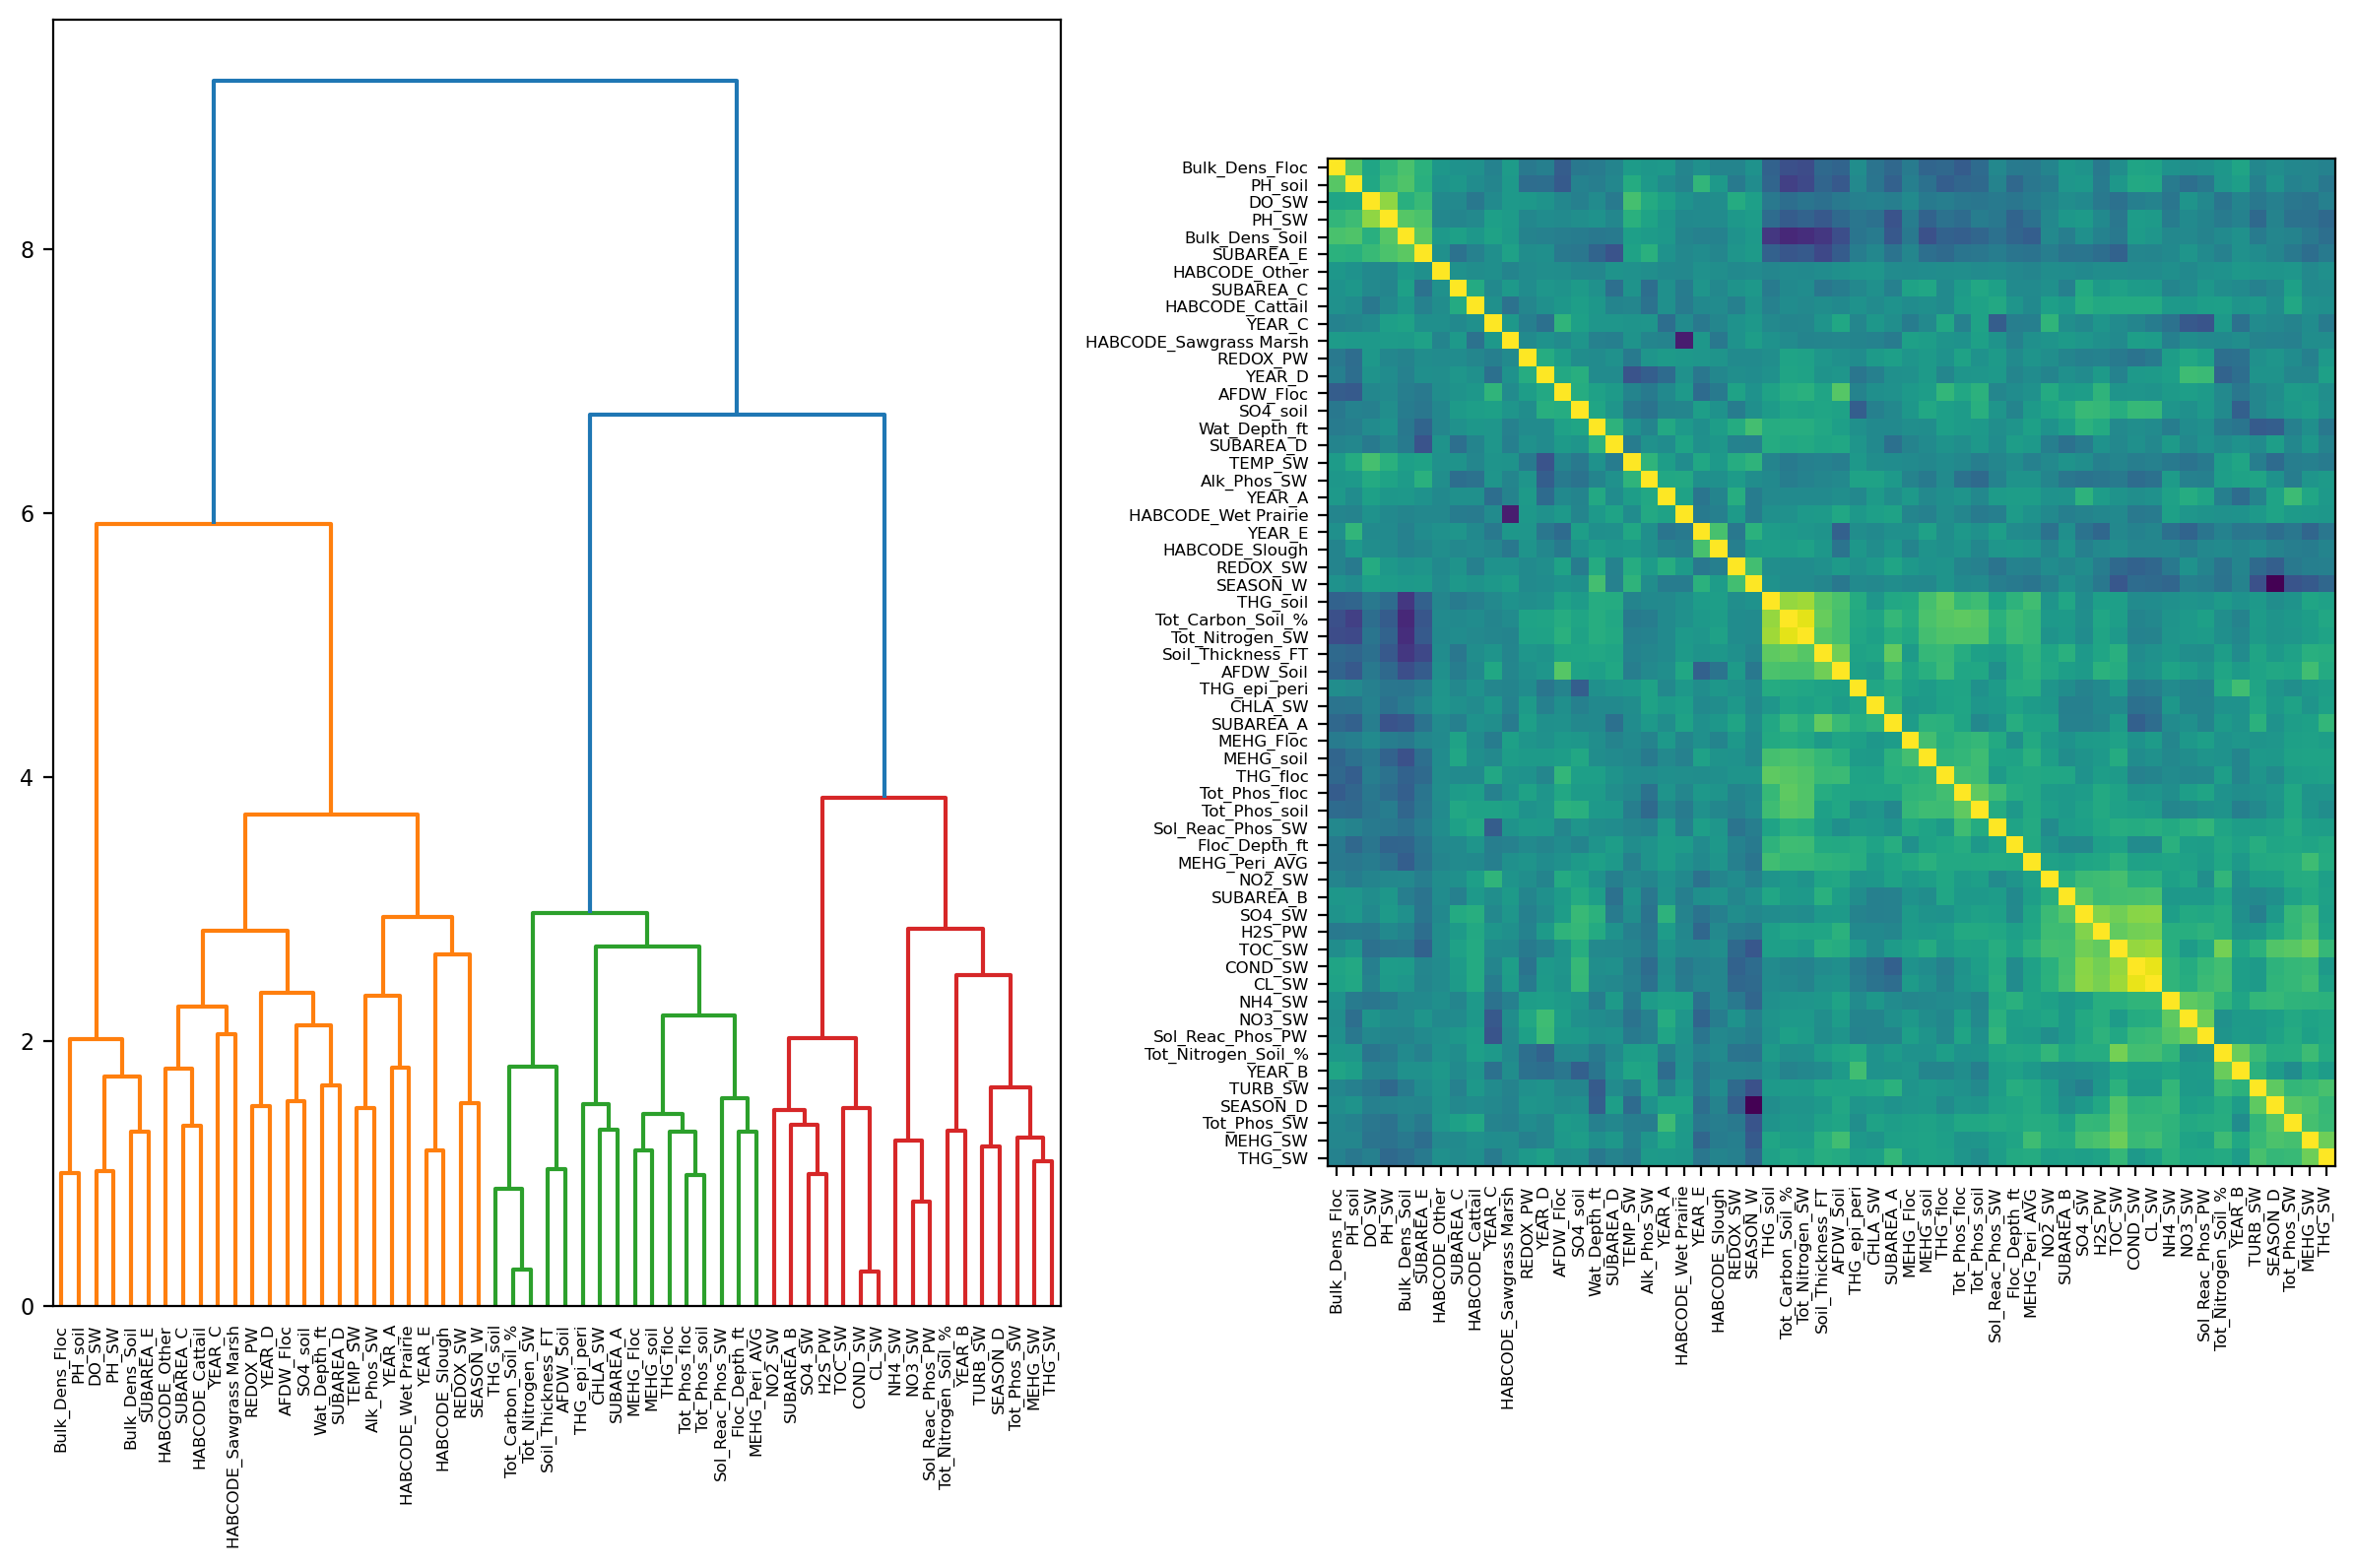

In [10]:
vbhelper.summarize()

In [11]:
-

SyntaxError: invalid syntax (<ipython-input-11-60215a10e730>, line 1)

### setup the analytical pipelines
#### note the inner_cv_dict and prep_dict that are used to consolidate vb_estimator kwargs and to facilitate the divison between prep and post steps.

In [ ]:
inner_cv_dict={'cv_reps':1,'cv_folds':5,'cv_strategy':('quantile',5)}
inner_cv=vbhelper.getCV(cv_dict=inner_cv_dict)

prep_dict={'impute_strategy':'impute_knn5','cat_idx':vbhelper.cat_idx}

needs_prep=not vbhelper.run_stacked

pipe_kwargs=dict(do_prep=needs_prep,prep_dict=prep_dict,inner_cv=inner_cv,gridpoints=gridpoints,cat_idx=vbhelper.cat_idx,float_idx=vbhelper.float_idx,bestT=False)
pipe_dict={
    'gradient-boosting-reg':{
        'pipe':GBR,
        'pipe_kwargs':dict(prep_dict=prep_dict,do_prep=needs_prep)
        },
    'rbf-svr-cv':{'pipe':RBFSVR,'pipe_kwargs':pipe_kwargs}, 
    'lassolars':{'pipe':L1Lars,'pipe_kwargs':pipe_kwargs},
    }
vbhelper.setPipeDict(pipe_dict) #formerly setEstimatorDict
vbhelper.setModelDict()


run cross validation

In [ ]:
start=time()
vbhelper.runCrossValidate(try_load=True)
end=time()
print(f'runtime:{(end-start)/60} min.\n')


---

### Fit the final models for all estimators

In [ ]:
vbhelper.refitPredictiveModels(selected_models=['multi_pipe'])

In [ ]:
yhat=vbhelper.predict(X_predict)

In [ ]:
yhat

In [ ]:
(yhat['prediction']['r2']-y_predict)/y_predict

In [ ]:
yhat_cv=vbhelper.predict(X_predict,model_type='cross_validation')

In [ ]:
#plot distribution of yhats
yhat_cv